# CRAFTY Web Scraping. Flavio Romano, 614801

In [18]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import json
import time
import re

"""Datasets"""
transactions = pd.read_csv("./datasets/transactions.csv", names=["timestamp", "blockId", "txId", "isCoinbase", "fee"])
inputs = pd.read_csv("./datasets/inputs.csv", names=["txId", "prevTxId", "prevTxPos"])
outputs = pd.read_csv("./datasets/outputs.csv", names=["txId", "position", "addressId", "amount", "scriptType"])
mapping_df = pd.read_csv("./datasets/mapAddr2Ids8708820.csv", names=["hash", "addressId"])

transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit='s')

## 1. Analisi generali sui dati

In [3]:
print(transactions.head())
print(inputs.head())
print(outputs.head())
print(mapping_df.head())

            timestamp  blockId  txId  isCoinbase  fee
0 2009-01-09 03:54:39        9     9           1    0
1 2009-01-11 01:00:54       78    78           1    0
2 2009-01-12 03:30:25      170   171           0    0
3 2009-01-12 06:02:13      181   183           0    0
4 2009-01-12 06:12:16      182   185           0    0
   txId  prevTxId  prevTxPos
0   171         9          0
1   183       171          1
2   185       183          1
3   187       185          1
4   192       187          0
   txId  position  addressId      amount  scriptType
0     9         0          9  5000000000           1
1    78         0         78  5000000000           1
2   171         0        171  1000000000           1
3   171         1          9  4000000000           1
4   183         0        183  1000000000           1
                                 hash  addressId
0  1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa          0
1  12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX          1
2  1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1

### I. Distribuzione del numero di transazioni per blocco (occupazione del blocco), nell’intero periodo temporale considerato

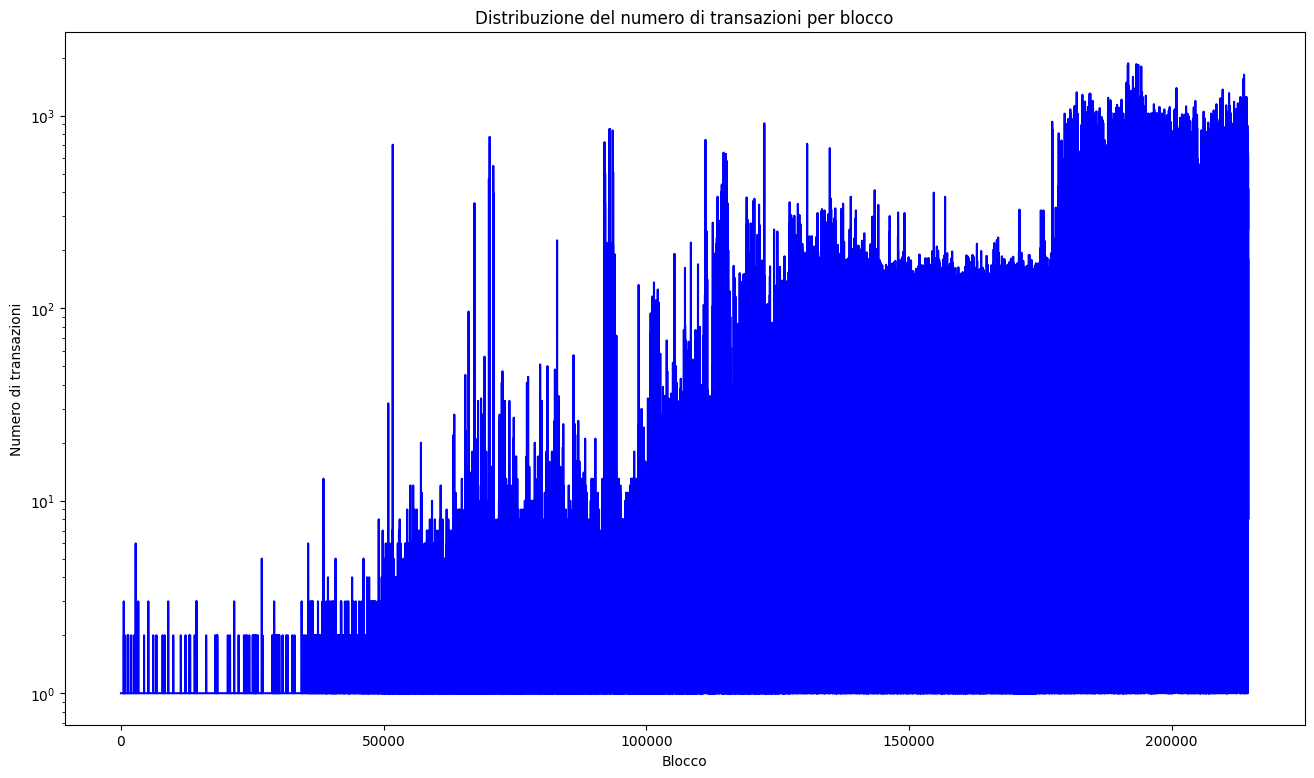

In [18]:
transactions_per_block = transactions.groupby("blockId")["txId"].count()

plt.figure(figsize=(16,9))
transactions_per_block.plot(color="blue")
plt.xlabel("Blocco")
plt.ylabel("Numero di transazioni")
plt.title("Distribuzione del numero di transazioni per blocco")

plt.yscale("log")

# x_ticks = range(0, len(transactions_per_block), 5000)
# plt.xticks(x_ticks, transactions_per_block.index[x_ticks], rotation=15)

plt.show()

### II. Evoluzione dell'occupazione dei blocchi nel tempo

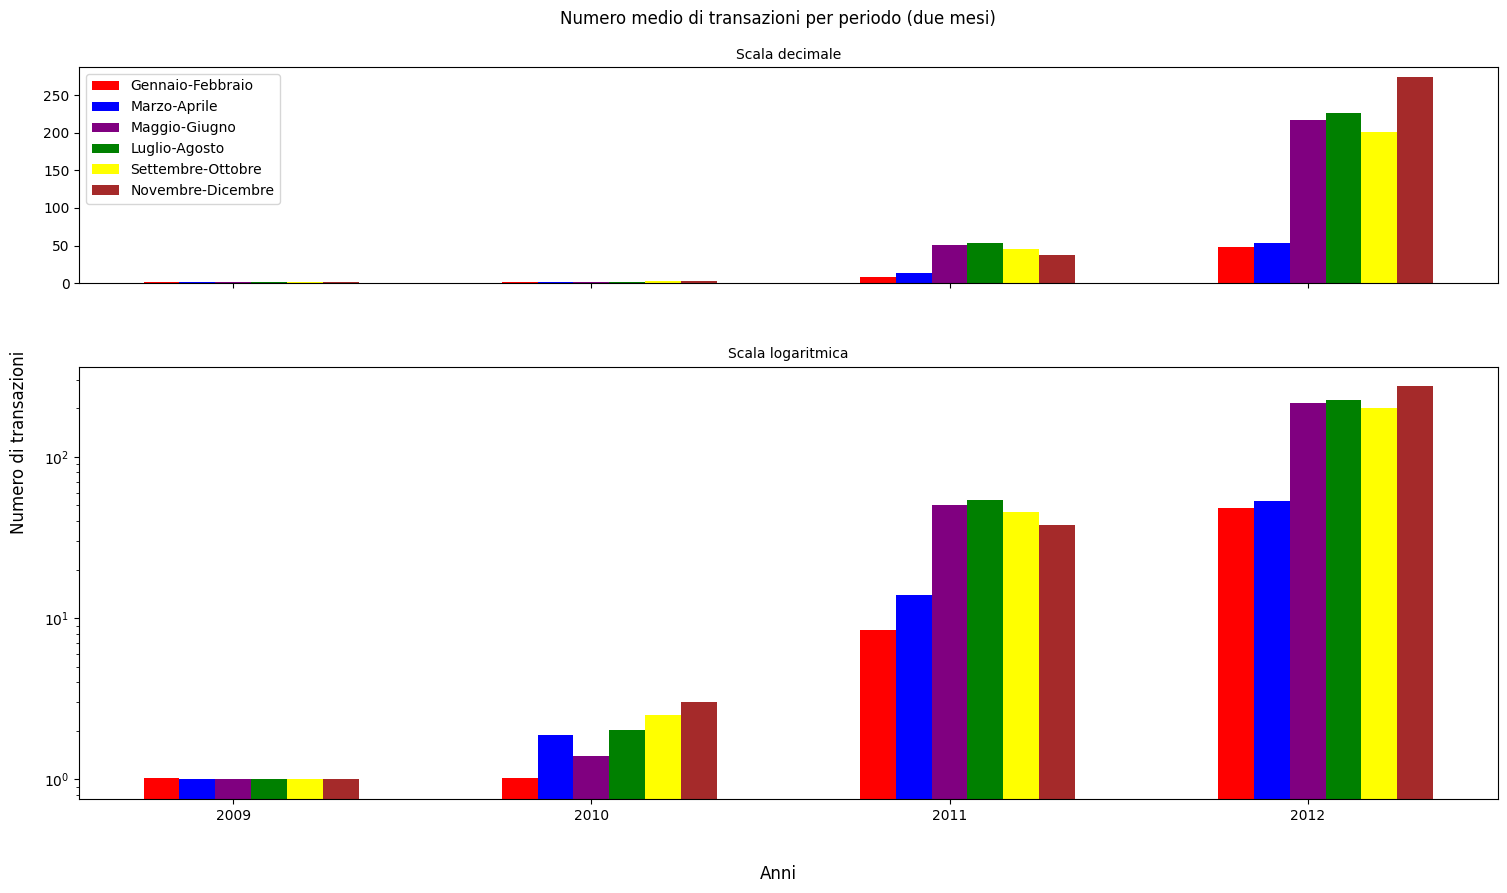

In [86]:
twoMonth_list = pd.date_range(start="2009-01-03", end="2012-12-31", freq="M")
months_dict = dict()
months_dict["jan-feb"] = list()
months_dict["mar-apr"] = list()
months_dict["may-jun"] = list()
months_dict["jul-aug"] = list()
months_dict["sept-oct"] = list()
months_dict["nov-dec"] = list()

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 9), gridspec_kw={'height_ratios': [1, 2]})
fig.tight_layout(pad=5)
fig.suptitle("Numero medio di transazioni per periodo (due mesi)")
fig.supylabel("Numero di transazioni")
fig.supxlabel("Anni")

for i in range(0, len(twoMonth_list)-1, 2):
    two_months = transactions[transactions['timestamp'].between(
        twoMonth_list[i], twoMonth_list[i + 1])]
    monthly_distribution_mean = two_months.groupby('blockId').size().mean()
    match twoMonth_list[i].month_name():
        case "January":
            months_dict["jan-feb"].append(monthly_distribution_mean)
        case "March":
            months_dict["mar-apr"].append(monthly_distribution_mean)
        case "May":
            months_dict["may-jun"].append(monthly_distribution_mean)
        case "July":
            months_dict["jul-aug"].append(monthly_distribution_mean)
        case "September":
            months_dict["sept-oct"].append(monthly_distribution_mean)
        case "November":
            months_dict["nov-dec"].append(monthly_distribution_mean)

x = np.array([1, 3, 5, 7])
width = .2

ax1.set_title("Scala decimale", fontsize=10)
ax1.bar(x - 2 * width, months_dict["jan-feb"], width, color='red')
ax1.bar(x - width, months_dict["mar-apr"], width, color='blue')
ax1.bar(x, months_dict["may-jun"], width, color='purple')
ax1.bar(x + width, months_dict["jul-aug"], width, color='green')
ax1.bar(x + 2 * width, months_dict["sept-oct"], width, color='yellow')
ax1.bar(x + 3 * width, months_dict["nov-dec"], width, color='brown')

ax2.set_title("Scala logaritmica", fontsize=10)
ax2.bar(x - 2 * width, months_dict["jan-feb"], width, color='red')
ax2.bar(x - width, months_dict["mar-apr"], width, color='blue')
ax2.bar(x, months_dict["may-jun"], width, color='purple')
ax2.bar(x + width, months_dict["jul-aug"], width, color='green')
ax2.bar(x + 2 * width, months_dict["sept-oct"], width, color='yellow')
ax2.bar(x + 3 * width, months_dict["nov-dec"], width, color='brown')

ax2.set_yscale("log")

plt.xticks(x, [2009, 2010, 2011, 2012])
ax1.legend(["Gennaio-Febbraio", "Marzo-Aprile", "Maggio-Giugno",
           "Luglio-Agosto", "Settembre-Ottobre", "Novembre-Dicembre"], loc="best")
plt.show()

### III. Ammontare totale degli UTXO al momento dell’ultima transazione

In [110]:
# output che sono stati input di una transazione
temp = outputs.merge(inputs, how='inner', left_on=["txId", "position"], right_on=["prevTxId", "prevTxPos"])
utxo = outputs.amount.sum() - temp.amount.sum()
print(utxo)  #  859303372614879

859303372614879


### IV. Distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un valore in output e quella che lo consuma

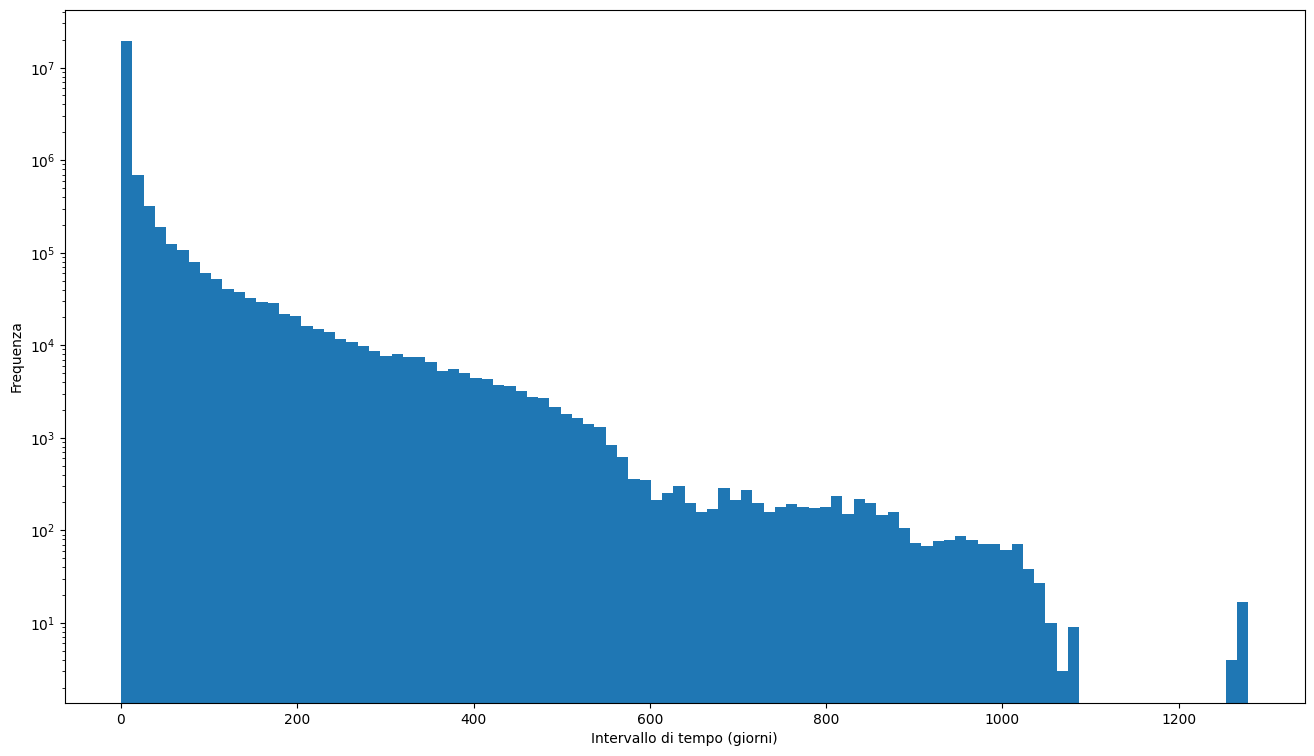

In [14]:
spent = transactions.merge(inputs, on="txId").rename(columns={"timestamp": "timestamp_spent"}).loc[:,["timestamp_spent", "txId", "prevTxId", "prevTxPos"]]
created = transactions.merge(outputs, on="txId").rename(columns={"timestamp": "timestamp_created"}).loc[:,["timestamp_created", "txId", "position"]]

diff = spent.merge(created.rename(columns={"txId": "outTxId"}), 
                   how="inner", left_on=["prevTxId", "prevTxPos"], 
                   right_on=["outTxId", "position"]).loc[:,["timestamp_created", "timestamp_spent"]]

diff["timestamp_difference"] = (diff.timestamp_spent - diff.timestamp_created).dt.days
diff.drop(diff[diff.timestamp_difference < 0].index, inplace=True) # rimuovo inconsistenze

plt.figure(figsize=(16, 9))
plt.hist(diff["timestamp_difference"], bins=100)
plt.yscale("log")
plt.xlabel("Intervallo di tempo (giorni)")
plt.ylabel("Frequenza")
plt.show()

### V. Evoluzione dei 3 address più ricchi (UTXO)

In [298]:
temp = (~outputs["txId"].isin(inputs["prevTxId"]))
utxo = outputs.loc[temp].loc[:,["addressId", "amount", "txId"]]
utxo_address = utxo.groupby(by="addressId").sum("amount").sort_values(by="amount", ascending=False).loc[:,["amount"]]
top_3_utxo = utxo_address.head(3).merge(mapping_df, how="inner", left_index=True, right_on="addressId").drop(columns=["addressId"])

address1, address2, address3 = top_3_utxo.index
print(top_3_utxo)


                amount                                hash
2770941  4972966980000  13vJZKHKBirruXwmjMaRtakzPQRRHQit1S
1083446  4716866106997  1933phfhK3ZgFQNLGSDXvqCn32k2buXY8a
6755311  4000000000000  1BqcwhKevdBKeos72b8E32Swjrp4iDVnjP


In [295]:
utxo_address1 = utxo.loc[utxo.addressId == address1].merge(transactions, on="txId").loc[:, ["addressId", "amount", "timestamp"]]
utxo_address2 = utxo.loc[utxo.addressId == address2].merge(transactions, on="txId").loc[:, ["addressId", "amount", "timestamp"]]
utxo_address3 = utxo.loc[utxo.addressId == address3].merge(transactions, on="txId").loc[:, ["addressId", "amount", "timestamp"]]

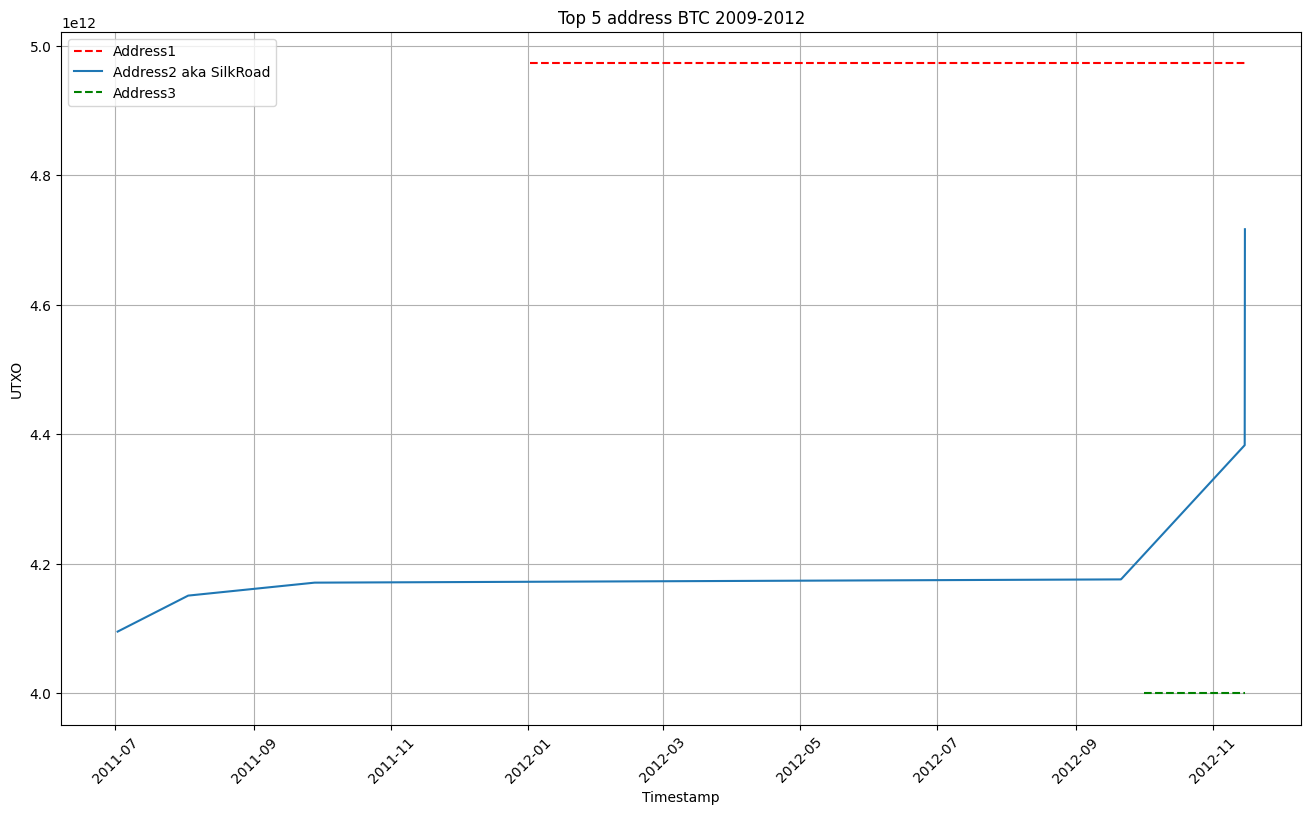

In [275]:
df_silkRoad = pd.DataFrame()
df_silkRoad.index = utxo_address2.timestamp
df_silkRoad["utxo"] = 0

for date in df_silkRoad.index:
    df_silkRoad.at[date, "utxo"] = utxo_address2.loc[utxo_address2["timestamp"] <= date].amount.sum()

timestamp_max = max(utxo_address1.timestamp.max(),
                    utxo_address2.timestamp.max(),
                    utxo_address3.timestamp.max())

plt.figure(figsize=(16, 9))

plt.hlines(y=top_3_utxo.loc[address1].amount,color='r', linestyle='--', label='Address1', xmin=utxo_address1.timestamp, xmax=timestamp_max)

plt.plot(df_silkRoad.index, df_silkRoad['utxo'], label="Address2 aka SilkRoad")
plt.hlines(y=df_silkRoad.loc[max(df_silkRoad.index)], xmin=max(df_silkRoad.index), xmax=timestamp_max)

plt.hlines(y=top_3_utxo.loc[address3].amount, color='g', linestyle='--', label='Address3', xmin=utxo_address3.timestamp, xmax=timestamp_max)

plt.xlabel('Timestamp')
plt.ylabel('UTXO')
plt.title('Top 5 address BTC 2009-2012')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc="upper left")

plt.show()

## 2. Clusterizzazione degli indirizzi di Bitcoin: euristica multi-input

In [68]:
# considerare transazioni con input > 1
inputs_transaction = inputs.merge(transactions, on="txId", how="inner").loc[:, ['txId', 'prevTxId', 'prevTxPos']]
tmp = inputs_transaction.groupby("txId")["prevTxId"].count() # index == txId's

# associare allo stesso utente tutti gli addressId utilizzati nell'input della stessa transazione
multi_inputs_transaction = (inputs_transaction.loc[inputs_transaction["txId"].isin(tmp.loc[tmp.values > 1].index)])
multi_inputs_transaction = multi_inputs_transaction.merge(outputs, left_on=["prevTxId", "prevTxPos"], right_on=["txId", "position"])
multi_inputs_transaction = multi_inputs_transaction.loc[:, ['txId_x', 'addressId']].rename(columns={"txId_x": "txId"}).set_index("addressId")
print(multi_inputs_transaction)

               txId
addressId          
367             504
192             504
255             504
555             557
533             557
...             ...
8707915    10572820
8707915    10572820
8707915    10572820
3524243    10572826
6137717    10572826

[14120915 rows x 1 columns]


In [69]:
# crea mapping (transazione: [indirizzi])
multi_inputs_dict = multi_inputs_transaction.groupby("txId").groups
print(multi_inputs_dict)

{504: [367, 192, 255], 557: [555, 533], 558: [557, 555], 559: [557, 557], 600: [275, 424, 438, 449, 457], 724: [509, 514], 746: [517, 364], 962: [610, 755, 788], 1075: [472, 480, 638, 573, 529, 500, 446, 773, 844, 840], 1077: [414, 680, 336, 550, 746, 830], 1206: [1009, 440, 604, 401, 789, 951, 966, 976], 1236: [901, 764], 1320: [327, 956, 1114, 468, 1143, 825, 1016, 1157, 962, 783], 1414: [1003, 943, 837], 1480: [621, 1316, 1260, 1211, 1319, 1353], 1613: [1015, 1289, 1154, 1132, 939, 1048, 1225, 866, 1001, 1153], 1974: [1162, 1137, 1534, 1541, 1643, 1597, 1600, 1613, 1757, 1735, 1742, 1765, 1362, 1403, 1420, 1419, 1417, 1418, 1411, 1620], 1997: [1738, 1790, 1681], 2308: [2132, 2140, 1927, 1923, 2102, 1849, 1859, 1961, 2151, 2178, 2020, 2062], 2550: [1492, 665, 1253, 835, 1059, 885, 1214, 1636, 983, 819, 1171, 1081, 1396, 858, 699, 426, 1546, 537, 1336, 768], 2649: [2509, 2483], 2863: [2840, 2840], 2864: [2840, 2840], 3358: [2411, 2109, 1939, 1946, 2566, 1990, 2513, 2542, 2055, 2321, 2

In [70]:
graph = nx.DiGraph()
graph.add_nodes_from(mapping_df["addressId"])

for addressIds in multi_inputs_dict.values():
    first_node = addressIds[0]
    for address in addressIds[1:]:
        if address != first_node:
            graph.add_edge(first_node, address)
nx.freeze(graph)

wcc = list(nx.weakly_connected_components(graph)) # lista di set di addressId

In [71]:
if len(list(nx.nodes_with_selfloops(graph))) != 0:
    print("> Error... trovato self loop con primo address")

# La classe DiGraph garantisce l'assenza di archi ripetuti.
# A prova di ciò:
for addressIds in multi_inputs_dict.values():
    first_node = addressIds[0]
    for address in addressIds[1:]:
        if graph.number_of_edges(first_node, address) > 1:
            print("> Error... trovato arco ripetuto")
            break

In [72]:
cluster_dim = [len(c) for c in wcc]
max_cluster = max(wcc, key=len)
mean_cluster = sum(cluster_dim)/len(cluster_dim)
min_cluster = min(wcc, key=len)
number_of_singlets = sum(1 for c in wcc if len(c) == 1)

print(f'{len(cluster_dim):9,} - #cluster')
print(f'{len(max_cluster):9,} - #cluster più grande')
print(f'{len(min_cluster):9} - #cluster più piccolo')
print(f'{mean_cluster:9.2f} - Dimensione media dei cluster')
print(f'{number_of_singlets:9,} - Numero di "singoletti"')

4,800,614 - #cluster
  259,773 - #cluster più grande
        1 - #cluster più piccolo
     1.81 - Dimensione media dei cluster
4,302,594 - Numero di "singoletti"


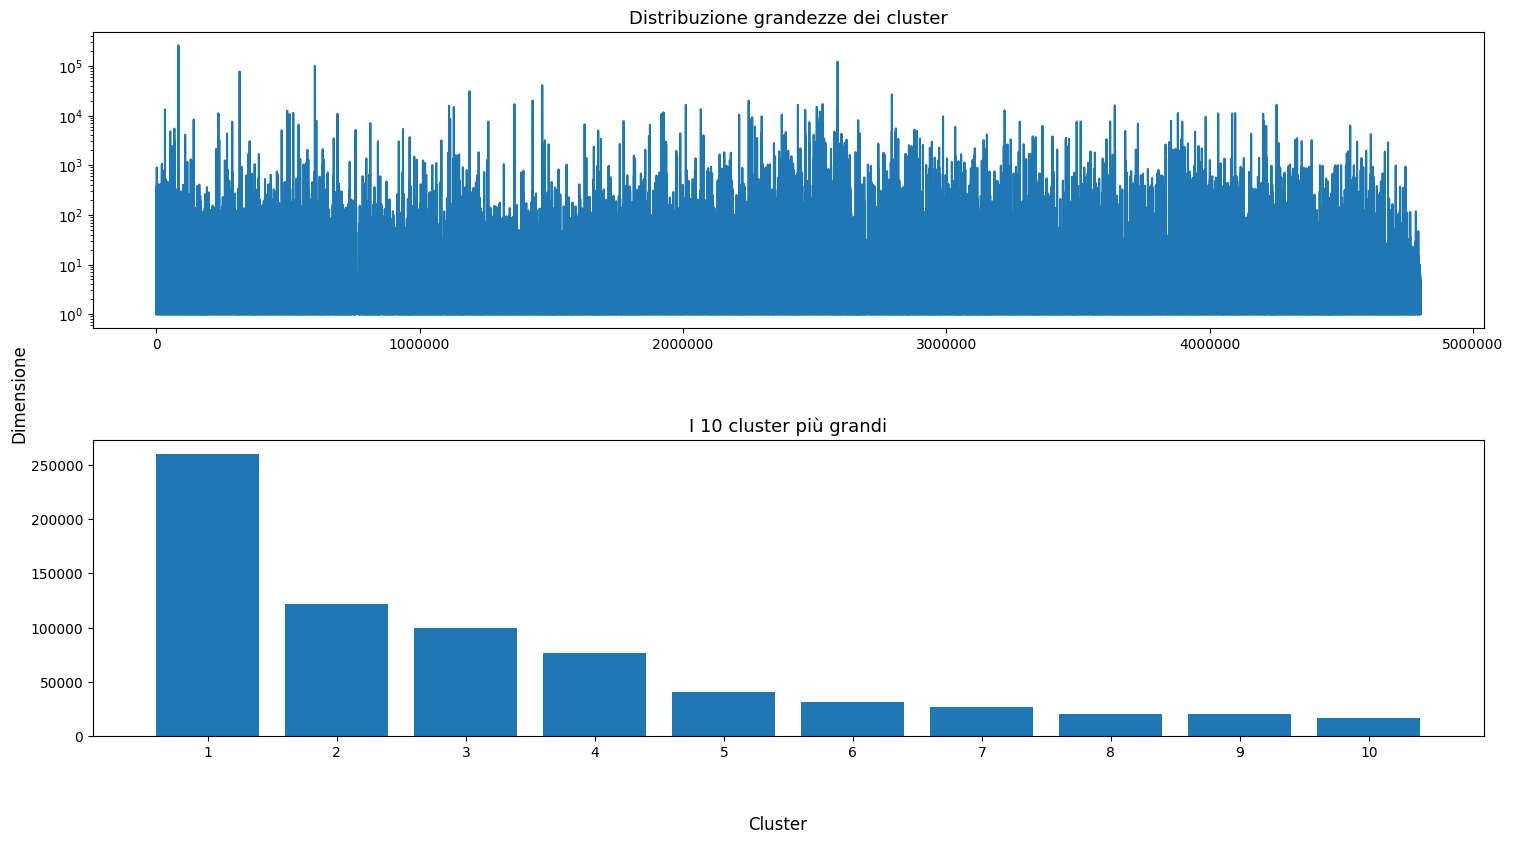

In [78]:
import heapq

biggest_clusters = heapq.nlargest(10, wcc, key=len)

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(16, 9))
fig.tight_layout(pad=6)
fig.supxlabel('Cluster')
fig.supylabel('Dimensione')

ax1.set_title("Distribuzione grandezze dei cluster", fontsize=13)
ax1.ticklabel_format(useOffset=False, style="plain")
ax1.set_yscale("log")
ax1.plot(cluster_dim)

ax2.set_title("I 10 cluster più grandi", fontsize=13)
xticks = range(1,11,1)
ax2.bar(x=xticks, height=[len(c) for c in biggest_clusters], tick_label=xticks)

plt.show()

## 3. Deanonimizzazione degli indirizzi

### WalletExplorer

In [39]:
from bs4 import BeautifulSoup
from http import client
import requests

# calcolo il rate limit
rate_limit = 1
while True:
    response = requests.get(f"http://www.walletexplorer.com/?q=1BqcwhKevdBKeos72b8E32Swjrp4iDVnjP")
    if response.ok:
       rate_limit += 1
    else:
        break 
    time.sleep(1)
    
print(rate_limit)

In [1]:
clusters_WalletExplorer = dict()
header = {"User-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"}
rate_limit = 10 # tipicamente si aggira tra 11 e 15, 10 è una scelta conservativa

def deanon_walletExplorer(cluster, it):
    with requests.Session() as session:
        try_limit = 0
        for addressId in cluster:
            if try_limit == 3:
                break
            if it == rate_limit:
                # rate limit reached
                it = 1
                try_limit += 1
                time.sleep(40)
            hash_addr = mapping_df.loc[mapping_df["addressId"] == addressId].iloc[0]["hash"]
            url = f"http://www.walletexplorer.com/?q={hash_addr}"
            try:
                response = session.get(url, headers=header)
                it += 1
                soup = BeautifulSoup(response.text, "html.parser")
                if response.ok:
                    try:
                        wallet_name = soup.find("h2").text.split()[1]
                        if re.match("\[.*?\]", wallet_name) is None:
                            return (wallet_name, it)
                    except AttributeError:
                        pass
            except (requests.exceptions.RequestException, client.RemoteDisconnected):
                pass
            time.sleep(1)
    return (None, it)

it = 1
for i, cluster in enumerate(biggest_clusters):
    cluster_name = f"Cluster{i+1}"
    print(f"Analyzing {cluster_name}...",end=" ")
    res, it = deanon_walletExplorer(cluster, it)
    print(f"{'*'if res is None else res}")
    clusters_WalletExplorer[cluster_name] = res

NameError: name 'biggest_clusters' is not defined

In [42]:
with open("./walletsWalletExplorer.json", "w+") as f:
    f.write(json.dumps(clusters_WalletExplorer, indent=8))

### Bitinfochart

In [45]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support import expected_conditions as EC

options = Options()
options.add_argument("--headless=new")
options.add_argument(
    "--user-agent=Mozilla/5.0 (Linux; Android 6.0; HTC One M9 Build/MRA58K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.98 Mobile Safari/537.36")


def deanon_BitInfoChart(cluster):
    try_limit = 0
    with webdriver.Chrome(options=options) as driver:
        for addressId in cluster:
            if try_limit == 20:
                break
            hash_addr = mapping_df.loc[mapping_df["addressId"]
                                    == addressId].iloc[0]["hash"]
            url = f"https://bitinfocharts.com/bitcoin/address/{hash_addr}"
            try:
                driver.get(url)
                WebDriverWait(driver, timeout=10, poll_frequency=1).until(
                    EC.text_to_be_present_in_element((By.XPATH, "/html/body/div[3]/h1/span"), hash_addr))
                r = driver.find_element(
                    By.XPATH, "/html/body/div[3]/div[3]/table/tbody/tr/td/table/tbody/tr[1]/td[2]/small/a")
                r = re.search("([A-Z])\w+", r.get_attribute("href"))
                try_limit += 1
                return r.group()
            except (NoSuchElementException, AttributeError):
                pass
    return None

clusters_BitInfoChart = dict()
for i, cluster in enumerate(biggest_clusters):
    cluster_name = f"Cluster{i+1}"
    print(f"Analyzing {cluster_name}...", end=" ")
    res = deanon_BitInfoChart(cluster)
    print(f"{'*'if res is None else res}")
    clusters_BitInfoChart[cluster_name] = res

Analyzing Cluster1... F2Pool
Analyzing Cluster2... SilkRoadMarketplace
Analyzing Cluster3... None
Analyzing Cluster4... Instawallet
Analyzing Cluster5... None
Analyzing Cluster6... Eligius
Analyzing Cluster7... None
Analyzing Cluster8... 

In [44]:
with open("./walletsBitInfoChart.json", "w+") as f:
    f.write(json.dumps(clusters_BitInfoChart, indent=8))